## Data Analysis of real-estate data
--Create a model to estimate the price of houses based on their size, number of rooms, location etc.

1. Data selection (Kaggle real-estate data: housing values in the city of Bengaluru)
2. Objective: The project aims to create a tool that can guess how much a house will cost using machine learning. This tool could help people like investors, banks and individulas to make better choices about buying and selling houses. By figuring out the prices more accurately, everyone can make smarter decisions and maybe even make more money.
3. Exploratory data Analysis
4. Feature engineering, data cleaning
   (1) Drop rows with missing data
   (2) For the total_sqft column, there are different types of data format: "100-150", "100 sqrt.meter", "100" etc.
   for those with "100-150", I calculate the average; for the rest of irregular format, we drop it.
   (3) Add a price_per_sqft column to test any outliers, and then remove them
   (4) For each location, there are gorups of data related to that location, for those location has few data, we group them and label them as "other"
5. Get the cleaned data and do machine learning on those data
   (1) Linear regression model
   (2) Decision Tree Model
6. Analysis on the result 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, when, split, col, isnan
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

In [0]:
storage_account_name = "tokyoolympicdatayifan"
container_name = "real-estate-data"
account_key = "f5QedKSsoWo4qv8aqmxo8LLRUIPYH8UMZ7TTruDZSXJovVPLYdiyhpDtz+ZBJy1QBcTWlEpr0x7w+ASt7Hmf4Q=="
mount_point = "/mnt/real-estate-data"  # Specify the mount point

# Check if the directory is already mounted
if not any(mount_info.mountPoint == mount_point for mount_info in dbutils.fs.mounts()):
    # Mount ADLS Gen2
    dbutils.fs.mount(
        source=f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net",
        mount_point=mount_point,
        extra_configs={"fs.azure.account.key." + storage_account_name + ".blob.core.windows.net": account_key}
    )




In [0]:
 %fs
 ls "/mnt/real-estate"

path,name,size,modificationTime
dbfs:/mnt/real-estate/cleaned-data/,cleaned-data/,0,0
dbfs:/mnt/real-estate/raw-data/,raw-data/,0,0


### Read data from Azure data lake -- Exploratory data Analysis

In [0]:
# csv_file_path = "/mnt/real-estate/raw-data/bengaluru_house_prices.csv"
# # Read the CSV file into a DataFrame
# df = pd.read_csv(csv_file_path)

# # Display the first few rows of the DataFrame
# df.head()
real_estate = spark.read.format("csv").options(header = 'True',inferSchema = 'True').load("/mnt/real-estate/raw-data/bengaluru_house_prices.csv")
real_estate.show()
num_rows = real_estate.count()
num_cols = len(real_estate.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")


+--------------------+-------------+--------------------+---------+-------+----------+----+-------+-----+
|           area_type| availability|            location|     size|society|total_sqft|bath|balcony|price|
+--------------------+-------------+--------------------+---------+-------+----------+----+-------+-----+
|Super built-up  Area|       19-Dec|Electronic City P...|    2 BHK|Coomee |      1056|   2|      1|39.07|
|          Plot  Area|Ready To Move|    Chikka Tirupathi|4 Bedroom|Theanmp|      2600|   5|      3|120.0|
|      Built-up  Area|Ready To Move|         Uttarahalli|    3 BHK|   NULL|      1440|   2|      3| 62.0|
|Super built-up  Area|Ready To Move|  Lingadheeranahalli|    3 BHK|Soiewre|      1521|   3|      1| 95.0|
|Super built-up  Area|Ready To Move|            Kothanur|    2 BHK|   NULL|      1200|   2|      1| 51.0|
|Super built-up  Area|Ready To Move|          Whitefield|    2 BHK|DuenaTa|      1170|   2|      1| 38.0|
|Super built-up  Area|       18-May|    Old Ai

In [0]:
real_estate.printSchema()
real_estate.dropDuplicates

root
 |-- area_type: string (nullable = true)
 |-- availability: string (nullable = true)
 |-- location: string (nullable = true)
 |-- size: string (nullable = true)
 |-- society: string (nullable = true)
 |-- total_sqft: string (nullable = true)
 |-- bath: integer (nullable = true)
 |-- balcony: integer (nullable = true)
 |-- price: double (nullable = true)



<bound method DataFrame.dropDuplicates of DataFrame[area_type: string, availability: string, location: string, size: string, society: string, total_sqft: string, bath: int, balcony: int, price: double]>

In [0]:
# Drop unnecessary columns from the DataFrame
real_estate = real_estate.drop("area_type", "society", "balcony", "availability")
real_estate.show()

+--------------------+---------+----------+----+-----+
|            location|     size|total_sqft|bath|price|
+--------------------+---------+----------+----+-----+
|Electronic City P...|    2 BHK|      1056|   2|39.07|
|    Chikka Tirupathi|4 Bedroom|      2600|   5|120.0|
|         Uttarahalli|    3 BHK|      1440|   2| 62.0|
|  Lingadheeranahalli|    3 BHK|      1521|   3| 95.0|
|            Kothanur|    2 BHK|      1200|   2| 51.0|
|          Whitefield|    2 BHK|      1170|   2| 38.0|
|    Old Airport Road|    4 BHK|      2732|   4|204.0|
|        Rajaji Nagar|    4 BHK|      3300|   4|600.0|
|        Marathahalli|    3 BHK|      1310|   3|63.25|
|        Gandhi Bazar|6 Bedroom|      1020|   6|370.0|
|          Whitefield|    3 BHK|      1800|   2| 70.0|
|          Whitefield|4 Bedroom|      2785|   5|295.0|
|  7th Phase JP Nagar|    2 BHK|      1000|   2| 38.0|
|           Gottigere|    2 BHK|      1100|   2| 40.0|
|            Sarjapur|3 Bedroom|      2250|   3|148.0|
|         

In [0]:

# count of missing values in each column
null_counts_df = real_estate.select([count(when(col(c).isNull(), c)).alias(c) for c in real_estate.columns])

display(null_counts_df)





location,size,total_sqft,bath,price
1,16,0,73,0


In [0]:
# Drop rows with missing values
real_estate = real_estate.dropna()
real_estate.show()
num_rows = real_estate.count()
num_cols = len(real_estate.columns)
# used to be 13320 rows , after dropping there are 13246 rows
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

+--------------------+---------+----------+----+-----+
|            location|     size|total_sqft|bath|price|
+--------------------+---------+----------+----+-----+
|Electronic City P...|    2 BHK|      1056|   2|39.07|
|    Chikka Tirupathi|4 Bedroom|      2600|   5|120.0|
|         Uttarahalli|    3 BHK|      1440|   2| 62.0|
|  Lingadheeranahalli|    3 BHK|      1521|   3| 95.0|
|            Kothanur|    2 BHK|      1200|   2| 51.0|
|          Whitefield|    2 BHK|      1170|   2| 38.0|
|    Old Airport Road|    4 BHK|      2732|   4|204.0|
|        Rajaji Nagar|    4 BHK|      3300|   4|600.0|
|        Marathahalli|    3 BHK|      1310|   3|63.25|
|        Gandhi Bazar|6 Bedroom|      1020|   6|370.0|
|          Whitefield|    3 BHK|      1800|   2| 70.0|
|          Whitefield|4 Bedroom|      2785|   5|295.0|
|  7th Phase JP Nagar|    2 BHK|      1000|   2| 38.0|
|           Gottigere|    2 BHK|      1100|   2| 40.0|
|            Sarjapur|3 Bedroom|      2250|   3|148.0|
|         

In [0]:

# add another column called 'BHK'
real_estate = real_estate.withColumn('BHK', split(col('size'), ' ')[0].cast('integer'))
real_estate.show()

+--------------------+---------+----------+----+-----+---+
|            location|     size|total_sqft|bath|price|BHK|
+--------------------+---------+----------+----+-----+---+
|Electronic City P...|    2 BHK|      1056|   2|39.07|  2|
|    Chikka Tirupathi|4 Bedroom|      2600|   5|120.0|  4|
|         Uttarahalli|    3 BHK|      1440|   2| 62.0|  3|
|  Lingadheeranahalli|    3 BHK|      1521|   3| 95.0|  3|
|            Kothanur|    2 BHK|      1200|   2| 51.0|  2|
|          Whitefield|    2 BHK|      1170|   2| 38.0|  2|
|    Old Airport Road|    4 BHK|      2732|   4|204.0|  4|
|        Rajaji Nagar|    4 BHK|      3300|   4|600.0|  4|
|        Marathahalli|    3 BHK|      1310|   3|63.25|  3|
|        Gandhi Bazar|6 Bedroom|      1020|   6|370.0|  6|
|          Whitefield|    3 BHK|      1800|   2| 70.0|  3|
|          Whitefield|4 Bedroom|      2785|   5|295.0|  4|
|  7th Phase JP Nagar|    2 BHK|      1000|   2| 38.0|  2|
|           Gottigere|    2 BHK|      1100|   2| 40.0|  

In [0]:
real_estate.select('BHK').distinct().show()

+---+
|BHK|
+---+
| 27|
| 12|
|  1|
| 13|
|  6|
| 16|
|  3|
|  5|
| 19|
| 43|
|  9|
|  4|
|  8|
|  7|
| 10|
| 11|
| 14|
|  2|
| 18|
+---+



In [0]:
# filter out values in the column "total_sqft" that are not float type
real_estate.filter(~col("total_sqft").cast("float").isNotNull()).head(10)

[Row(location='Yelahanka', size='4 BHK', total_sqft='2100 - 2850', bath=4, price=186.0, BHK=4),
 Row(location='Hebbal', size='4 BHK', total_sqft='3067 - 8156', bath=4, price=477.0, BHK=4),
 Row(location='8th Phase JP Nagar', size='2 BHK', total_sqft='1042 - 1105', bath=2, price=54.005, BHK=2),
 Row(location='Sarjapur', size='2 BHK', total_sqft='1145 - 1340', bath=2, price=43.49, BHK=2),
 Row(location='KR Puram', size='2 BHK', total_sqft='1015 - 1540', bath=2, price=56.8, BHK=2),
 Row(location='Kengeri', size='1 BHK', total_sqft='34.46Sq. Meter', bath=1, price=18.5, BHK=1),
 Row(location='Hennur Road', size='2 BHK', total_sqft='1195 - 1440', bath=2, price=63.77, BHK=2),
 Row(location='Arekere', size='9 Bedroom', total_sqft='4125Perch', bath=9, price=265.0, BHK=9),
 Row(location='Yelahanka', size='2 BHK', total_sqft='1120 - 1145', bath=2, price=48.13, BHK=2),
 Row(location='Bettahalsoor', size='4 Bedroom', total_sqft='3090 - 5002', bath=4, price=445.0, BHK=4)]

In [0]:


# Define the UDF to convert sqft to numeric value
@udf(FloatType())
def convert_sqft_to_num(x):
    token = x.split('-')
    if len(token) == 2:
        return (float(token[0]) + float(token[1])) / 2
    try:
        return float(x)
    except:
        return None
    



In [0]:
convert_sqft_to_num('1145 - 1340')

Column<'convert_sqft_to_num(1145 - 1340)'>

In [0]:
# Apply the UDF to the 'total_sqft' column
real_estate_copy = real_estate.select([col(col_name) for col_name in real_estate.columns])
real_estate_copy = real_estate_copy.withColumn('total_sqft', convert_sqft_to_num(col('total_sqft')))
real_estate_copy.show()


+--------------------+---------+----------+----+-----+---+
|            location|     size|total_sqft|bath|price|BHK|
+--------------------+---------+----------+----+-----+---+
|Electronic City P...|    2 BHK|    1056.0|   2|39.07|  2|
|    Chikka Tirupathi|4 Bedroom|    2600.0|   5|120.0|  4|
|         Uttarahalli|    3 BHK|    1440.0|   2| 62.0|  3|
|  Lingadheeranahalli|    3 BHK|    1521.0|   3| 95.0|  3|
|            Kothanur|    2 BHK|    1200.0|   2| 51.0|  2|
|          Whitefield|    2 BHK|    1170.0|   2| 38.0|  2|
|    Old Airport Road|    4 BHK|    2732.0|   4|204.0|  4|
|        Rajaji Nagar|    4 BHK|    3300.0|   4|600.0|  4|
|        Marathahalli|    3 BHK|    1310.0|   3|63.25|  3|
|        Gandhi Bazar|6 Bedroom|    1020.0|   6|370.0|  6|
|          Whitefield|    3 BHK|    1800.0|   2| 70.0|  3|
|          Whitefield|4 Bedroom|    2785.0|   5|295.0|  4|
|  7th Phase JP Nagar|    2 BHK|    1000.0|   2| 38.0|  2|
|           Gottigere|    2 BHK|    1100.0|   2| 40.0|  

In [0]:

real_estate_copy = real_estate_copy.withColumn('price_per_sqft', col('price') * 100000 / col('total_sqft'))
real_estate_copy.show()

+--------------------+---------+----------+----+-----+---+------------------+
|            location|     size|total_sqft|bath|price|BHK|    price_per_sqft|
+--------------------+---------+----------+----+-----+---+------------------+
|Electronic City P...|    2 BHK|    1056.0|   2|39.07|  2| 3699.810606060606|
|    Chikka Tirupathi|4 Bedroom|    2600.0|   5|120.0|  4| 4615.384615384615|
|         Uttarahalli|    3 BHK|    1440.0|   2| 62.0|  3| 4305.555555555556|
|  Lingadheeranahalli|    3 BHK|    1521.0|   3| 95.0|  3| 6245.890861275477|
|            Kothanur|    2 BHK|    1200.0|   2| 51.0|  2|            4250.0|
|          Whitefield|    2 BHK|    1170.0|   2| 38.0|  2| 3247.863247863248|
|    Old Airport Road|    4 BHK|    2732.0|   4|204.0|  4|7467.0571010248905|
|        Rajaji Nagar|    4 BHK|    3300.0|   4|600.0|  4| 18181.81818181818|
|        Marathahalli|    3 BHK|    1310.0|   3|63.25|  3| 4828.244274809161|
|        Gandhi Bazar|6 Bedroom|    1020.0|   6|370.0|  6|36274.

In [0]:
len(real_estate_copy.select(col("location")).distinct().collect())

1304

In [0]:
from pyspark.sql.functions import trim

real_estate_copy = real_estate_copy.withColumn("location", trim(real_estate_copy.location))
location_stats = real_estate_copy.groupby('location').agg(count('location').alias('location_count')).orderBy('location_count', ascending=False)
location_stats.show()

+--------------------+--------------+
|            location|location_count|
+--------------------+--------------+
|          Whitefield|           535|
|      Sarjapur  Road|           392|
|     Electronic City|           304|
|      Kanakpura Road|           266|
|         Thanisandra|           236|
|           Yelahanka|           210|
|         Uttarahalli|           186|
|              Hebbal|           176|
|        Marathahalli|           175|
|Raja Rajeshwari N...|           171|
|   Bannerghatta Road|           152|
|         Hennur Road|           150|
|  7th Phase JP Nagar|           149|
|        Haralur Road|           141|
|Electronic City P...|           131|
|        Rajaji Nagar|           106|
|          Chandapura|            98|
|           Bellandur|            96|
|            KR Puram|            88|
|               Hoodi|            88|
+--------------------+--------------+
only showing top 20 rows



In [0]:
# after group by the collection name, there are 1293 unique locations
len(real_estate_copy.select(col("location")).distinct().collect())

1293

In [0]:
# we want to find the location_count <= 10, group them together as 'other'

# filter location_stats based on location_count <= 10
location_stats_less_than_10 = location_stats.filter(location_stats['location_count'] <= 10)

# collect the unique values in the 'location' column as a list
location_stats_less_than_10_list = location_stats_less_than_10.select("location").distinct().rdd.flatMap(lambda x: x).collect()

# update the 'location' column using the when() and otherwise() functions

real_estate_copy = real_estate_copy.withColumn("location",
                                               when(col("location").isin(location_stats_less_than_10_list), "other")
                                               .otherwise(col("location")))
real_estate_copy.show()
# count the unique values in the 'location' column
unique_location_count = real_estate_copy.select("location").distinct().count()

+--------------------+---------+----------+----+-----+---+------------------+
|            location|     size|total_sqft|bath|price|BHK|    price_per_sqft|
+--------------------+---------+----------+----+-----+---+------------------+
|Electronic City P...|    2 BHK|    1056.0|   2|39.07|  2| 3699.810606060606|
|    Chikka Tirupathi|4 Bedroom|    2600.0|   5|120.0|  4| 4615.384615384615|
|         Uttarahalli|    3 BHK|    1440.0|   2| 62.0|  3| 4305.555555555556|
|  Lingadheeranahalli|    3 BHK|    1521.0|   3| 95.0|  3| 6245.890861275477|
|            Kothanur|    2 BHK|    1200.0|   2| 51.0|  2|            4250.0|
|          Whitefield|    2 BHK|    1170.0|   2| 38.0|  2| 3247.863247863248|
|    Old Airport Road|    4 BHK|    2732.0|   4|204.0|  4|7467.0571010248905|
|        Rajaji Nagar|    4 BHK|    3300.0|   4|600.0|  4| 18181.81818181818|
|        Marathahalli|    3 BHK|    1310.0|   3|63.25|  3| 4828.244274809161|
|               other|6 Bedroom|    1020.0|   6|370.0|  6|36274.

In [0]:
real_estate_copy[real_estate_copy.total_sqft/real_estate_copy.BHK<300].head()

Row(location='other', size='6 Bedroom', total_sqft=1020.0, bath=6, price=370.0, BHK=6, price_per_sqft=36274.509803921566)

In [0]:
# we want BHK >= 300
real_estate_copy = real_estate_copy[~(real_estate_copy.total_sqft/real_estate_copy.BHK<300)]


In [0]:
real_estate_copy.select("price_per_sqft").describe().show()

+-------+------------------+
|summary|    price_per_sqft|
+-------+------------------+
|  count|             12456|
|   mean| 6308.502826086313|
| stddev|4168.1273384332335|
|    min|267.82981328435875|
|    max|176470.58823529413|
+-------+------------------+



In [0]:
# def remove_pps_outliers(df):
#     df_out = pd.DataFrame()
#     df_pandas = df.toPandas()  # Convert GroupedData to DataFrame
#     for key, subdf in df_pandas.groupby('location'):
#         m = np.mean(subdf.price_per_sqft)
#         st = np.std(subdf.price_per_sqft)
#         reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
#         df_out = pd.concat([df_out, reduced_df], ignore_index=True)
#     return df_out

# new = remove_pps_outliers(real_estate_copy)
from pyspark.sql.functions import mean, stddev_pop, col

def remove_pps_outliers(df):
    # Calculate mean and standard deviation of price_per_sqft for each location
    stats_df = df.groupBy('location').agg(mean('price_per_sqft').alias('mean_pps'), 
                                           stddev_pop('price_per_sqft').alias('std_pps'))
    
    # Join the statistics with the original DataFrame
    df_with_stats = df.join(stats_df, on='location', how='inner')
    
    # Filter out outliers based on mean and standard deviation
    df_out = df_with_stats.filter((col('price_per_sqft') > (col('mean_pps') - col('std_pps'))) & 
                                  (col('price_per_sqft') <= (col('mean_pps') + col('std_pps'))))
    
    return df_out

new = remove_pps_outliers(real_estate_copy)


In [0]:
new.show()

+--------------------+---------+----------+----+-----+---+------------------+------------------+------------------+
|            location|     size|total_sqft|bath|price|BHK|    price_per_sqft|          mean_pps|           std_pps|
+--------------------+---------+----------+----+-----+---+------------------+------------------+------------------+
|Electronic City P...|    2 BHK|    1056.0|   2|39.07|  2| 3699.810606060606|3827.1555577360914| 2137.712530861059|
|    Chikka Tirupathi|4 Bedroom|    2600.0|   5|120.0|  4| 4615.384615384615| 4468.307828348118|   903.53276236815|
|         Uttarahalli|    3 BHK|    1440.0|   2| 62.0|  3| 4305.555555555556|  4292.08423382844| 1289.671809587883|
|  Lingadheeranahalli|    3 BHK|    1521.0|   3| 95.0|  3| 6245.890861275477| 6613.525330900519| 699.1687001786811|
|            Kothanur|    2 BHK|    1200.0|   2| 51.0|  2|            4250.0| 5483.294629003022|1593.7721496466847|
|          Whitefield|    2 BHK|    1170.0|   2| 38.0|  2| 3247.86324786

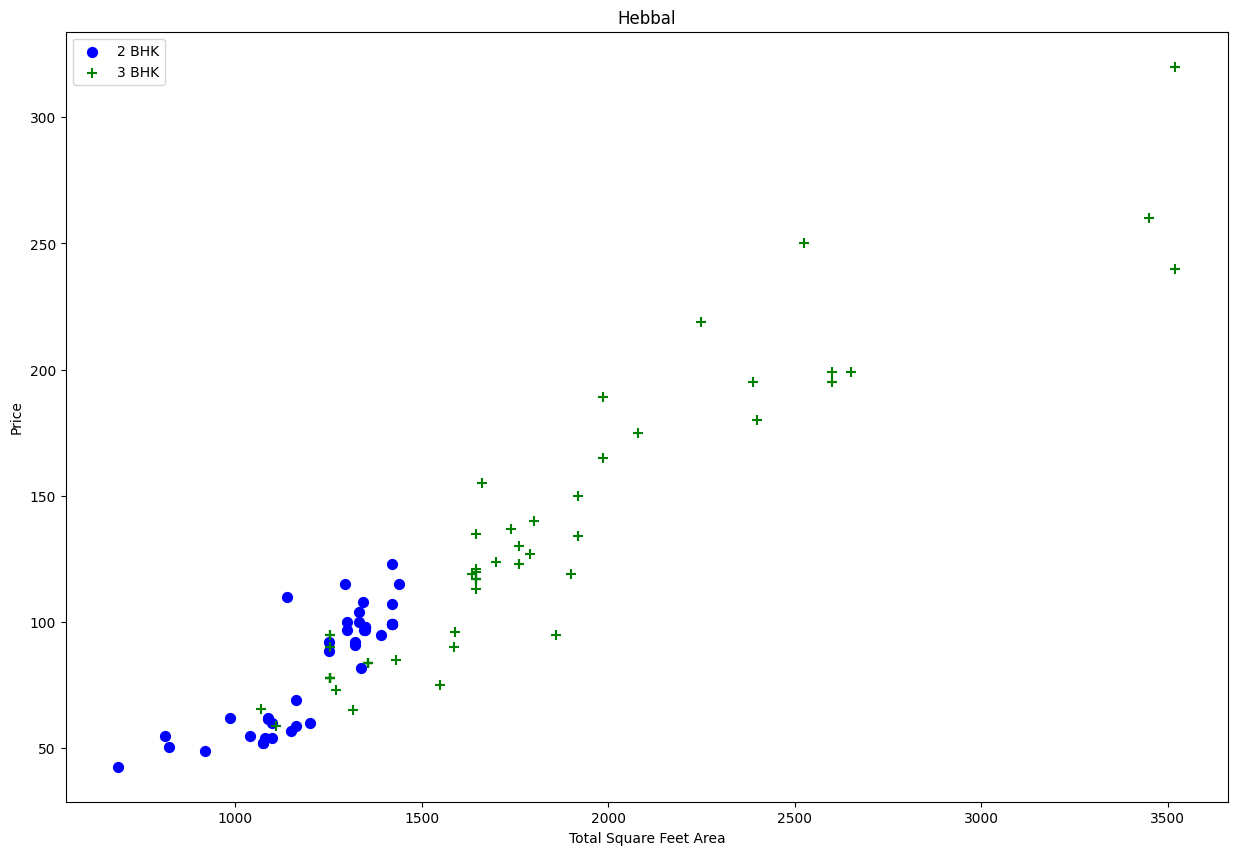

In [0]:
import matplotlib.pyplot as plt

def plot_scatter_chart(df, location):
    BHK2 = df[(df.location==location) & (df.BHK==2)]
    BHK3 = df[(df.location==location) & (df.BHK==3)]
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(BHK2.total_sqft, BHK2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(BHK3.total_sqft, BHK3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

# plot_scatter_chart(new, "Rajaji Nagar")
# def plot_scatter_chart(df, location):
#     BHK2 = df.filter((df["location"] == location) & (df["BHK"] == 2))
#     BHK3 = df.filter((df["location"] == location) & (df["BHK"] == 3))
#     plt.rcParams['figure.figsize'] = (15, 10)
#     plt.scatter(BHK2.select("total_sqft").collect(), BHK2.select("price").collect(), color='blue', label='2 BHK', s=50)
#     plt.scatter(BHK3.select("total_sqft").collect(), BHK3.select("price").collect(), marker='+', color='green', label='3 BHK', s=50)
#     plt.xlabel("Total Square Feet Area")
#     plt.ylabel("Price (Lakh Indian Rupees)")
#     plt.title(location)
#     plt.legend()
#     plt.show()
# Convert PySpark DataFrame to Pandas DataFrame
new_pandas = new.toPandas()

plot_scatter_chart(new_pandas, "Hebbal")


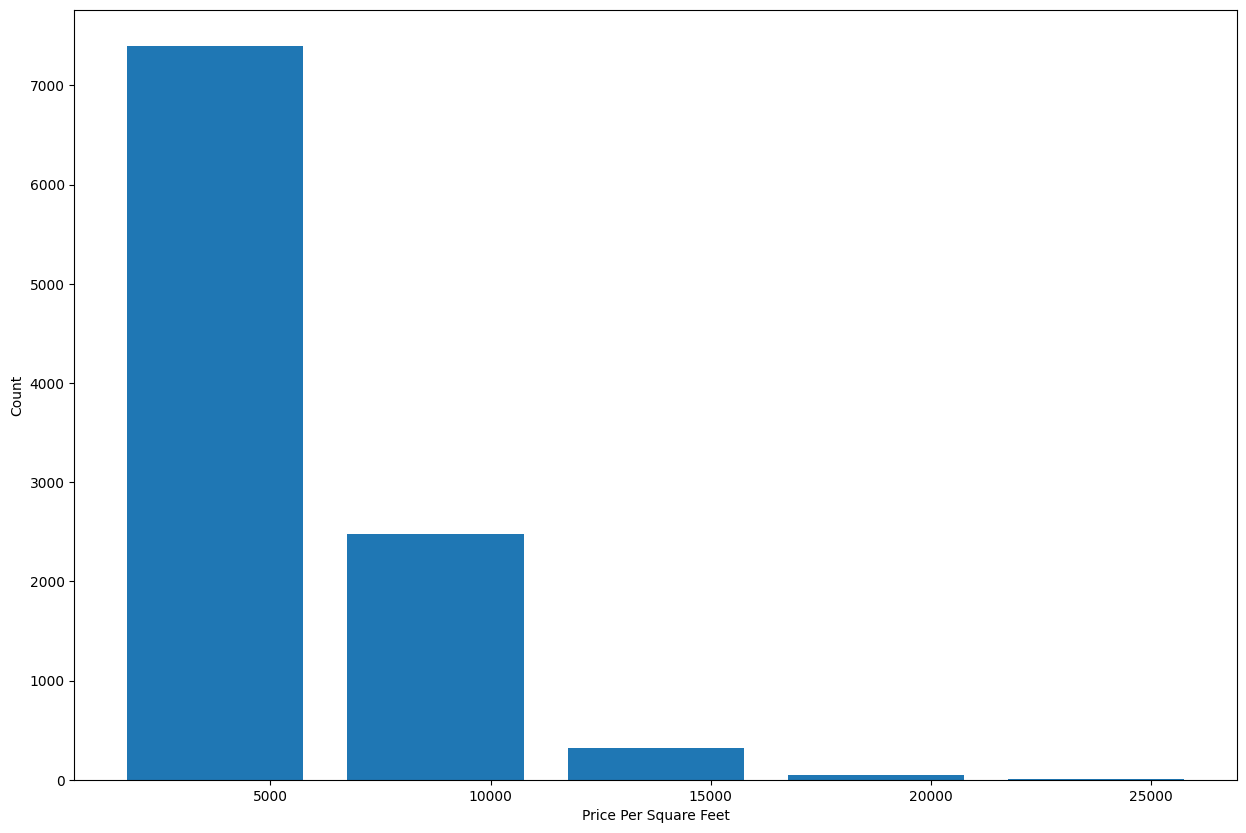

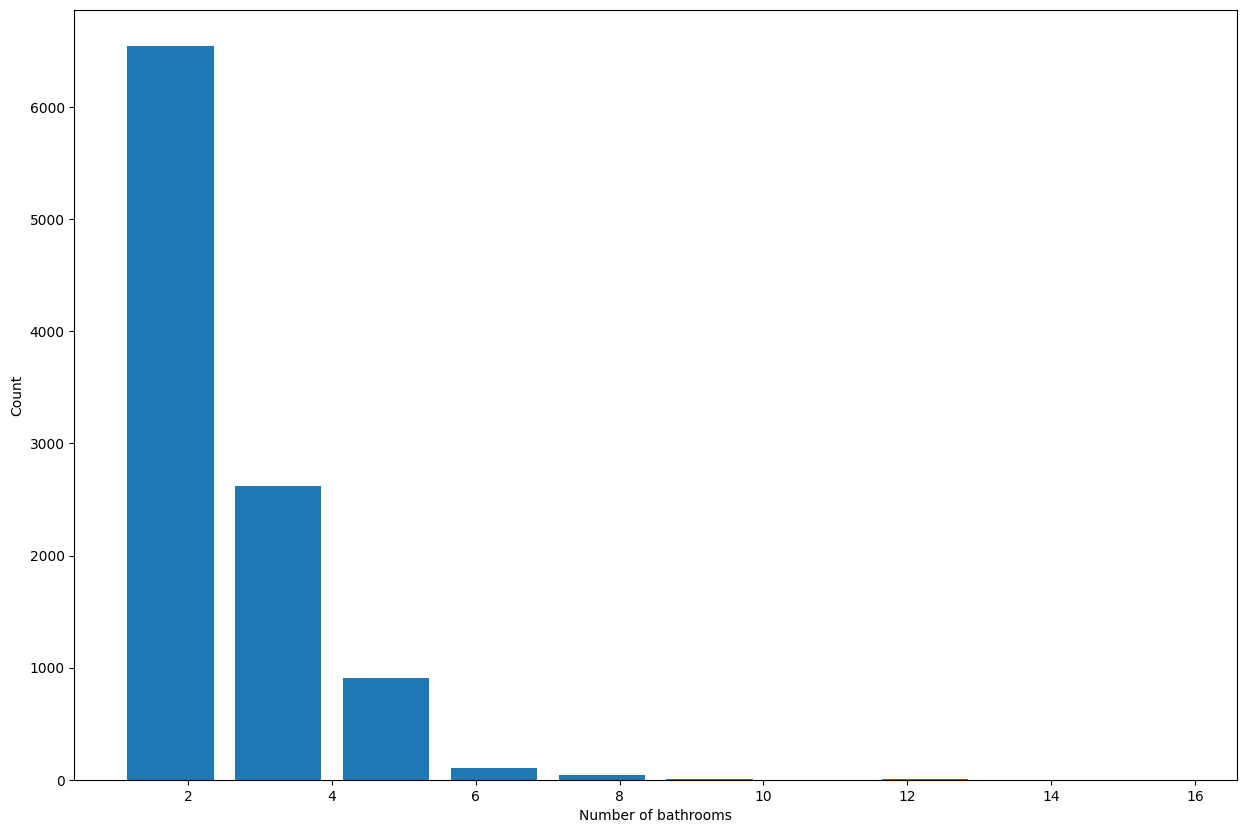

In [0]:

import matplotlib.pyplot as plt
import pandas as pd
# Convert Spark DataFrame column to Pandas
price_per_sqft_pd = new.select("price_per_sqft").toPandas()
# Define bins
bins = range(int(price_per_sqft_pd['price_per_sqft'].min()), int(price_per_sqft_pd['price_per_sqft'].max()) + 5000, 5000)

# Plot histogram with adjusted x-axis range
plt.hist(price_per_sqft_pd['price_per_sqft'], bins=bins, rwidth=0.8)
#plt.hist(price_per_sqft_pd['price_per_sqft'], rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

bathroom_count = new.select("bath").toPandas()
plt.hist(bathroom_count,rwidth = 0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
plt.show()

In [0]:

new = new.filter(new.bath < new.BHK + 2)
# Dropping the 'size' and 'price_per_sqft' columns, since they are to determin the outliwers
new = new.drop('size', 'price_per_sqft')



In [0]:
new.printSchema()
new.show()

root
 |-- location: string (nullable = true)
 |-- total_sqft: float (nullable = true)
 |-- bath: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- BHK: integer (nullable = true)
 |-- mean_pps: double (nullable = true)
 |-- std_pps: double (nullable = true)

+--------------------+----------+----+-----+---+------------------+------------------+
|            location|total_sqft|bath|price|BHK|          mean_pps|           std_pps|
+--------------------+----------+----+-----+---+------------------+------------------+
|Electronic City P...|    1056.0|   2|39.07|  2|3827.1555577360914| 2137.712530861059|
|    Chikka Tirupathi|    2600.0|   5|120.0|  4| 4468.307828348118|   903.53276236815|
|         Uttarahalli|    1440.0|   2| 62.0|  3|  4292.08423382844| 1289.671809587883|
|  Lingadheeranahalli|    1521.0|   3| 95.0|  3| 6613.525330900519| 699.1687001786811|
|            Kothanur|    1200.0|   2| 51.0|  2| 5483.294629003022|1593.7721496466847|
|          Whitefield|    11

In [0]:
# Write PySpark DataFrame to CSV format
new.write.format("csv").option("header", "true").mode("overwrite").save("/mnt/real-estate-data/cleaned-data/cleaned_data.csv")


In [0]:
# Convert the PySpark DataFrame column to a pandas DataFrame
new_pandas_df = new.toPandas()

dummies = pd.get_dummies(new_pandas_df['location'])
print(dummies.head(3))

   1st Block Jayanagar  1st Phase JP Nagar  ...  Yeshwanthpur  other
0                    0                   0  ...             0      0
1                    0                   0  ...             0      0
2                    0                   0  ...             0      0

[3 rows x 242 columns]


In [0]:
new_pandas_df = pd.concat([new_pandas_df,dummies.drop('other',axis='columns')],axis='columns')
new_pandas_df.head()

,location,total_sqft,bath,price,BHK,mean_pps,std_pps,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Electronic City Phase II,1056.0,2,39.07,2,3827.155558,2137.712531,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Chikka Tirupathi,2600.0,5,120.00,4,4468.307828,903.532762,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Uttarahalli,1440.0,2,62.00,3,4292.084234,1289.671810,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lingadheeranahalli,1521.0,3,95.00,3,6613.525331,699.168700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Kothanur,1200.0,2,51.00,2,5483.294629,1593.772150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:

new_pandas_df = new_pandas_df.drop('location', axis='columns')
new_pandas_df.head()

,total_sqft,bath,price,BHK,mean_pps,std_pps,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1056.0,2,39.07,2,3827.155558,2137.712531,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2600.0,5,120.00,4,4468.307828,903.532762,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1440.0,2,62.00,3,4292.084234,1289.671810,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1521.0,3,95.00,3,6613.525331,699.168700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1200.0,2,51.00,2,5483.294629,1593.772150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#start prepare our sets
X = new_pandas_df.drop(['price'],axis='columns')
X.shape



(10147, 246)

In [0]:
y = new_pandas_df.price
len(y)

10147

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)


0.7548767429917617

In [0]:
y_pred = lr_clf.predict(X_test)
print("Predicted values:", y_pred)

Predicted values: [ 82.53539802  31.85394462  64.63550982 ... 119.6749701   53.50589546
  54.49563427]


In [0]:
from sklearn.tree import DecisionTreeRegressor
# Decision Tree Regression
dt_clf = DecisionTreeRegressor(random_state=10)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.7232558999370335